In [93]:
import numpy as np
import torch
import math
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import random


import torch.optim as optim
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error



# 1 Non-linear regression

In [94]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## 1.1 Data acquisition

We keep the Dataset wrapper from Ex. 02.

In [95]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y ).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

In Exercise 02, we manually split our data into training and test set. Since this is a standard procedure, it is helpful to write a function doing that for us. Feel free to modify it!

In [96]:
def split_data(x_full: np.ndarray,
               y_full: np.ndarray,
               train_fraction: float):
    """Generates three pytorch Datasets (full, train, test) given a set of features and labels."""

    # define fraction of data used for training
    assert x_full.shape[0] == y_full.shape[0]
    
    n_samples = y_full.shape[0]

    n_train = int(train_fraction * n_samples)

    # get indices for training and test set
    ids = np.arange(n_samples)
    np.random.shuffle(ids)
    ids_train, ids_test  = np.split(ids, [n_train])

    all_data = Data(x_full, y_full)
    train_data = Data(x_full[ids_train], y_full[ids_train])
    test_data = Data(x_full[ids_test], y_full[ids_test])

    return all_data, train_data, test_data

## 1.2 Neural network

In [97]:
class MLP(nn.Module):
    def __init__(self, n_units: list, activation= nn.ReLU()):
        """
            Simple multi-layer perceptron (MLP).

            Parameters:
            -----------
            n_units : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 


            Example:
            -----------

            dim_hidden = 100
            dim_in = 2
            dim_out = 5

            # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
            model = MLP([dim_in,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_out],activation=nn.ReLU()).to(DEVICE)

        """
        super().__init__()

        # Get input and output dimensions
        dims_in = n_units[:-1]
        dims_out = n_units[1:]

        layers = []

        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(torch.nn.Linear(dim_in, dim_out))
            
            if i < len(n_units) - 2:
                layers.append(activation)
        

        self._layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
            MLP forward pass

        """
        return self._layers(x)
    
    def count_parameters(self): 
        """
            Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In Exercise 02, we saw how a basic training loop in pytorch looks like. Since we will need this exact training procedure a number of times, it is useful to define a function for it. Feel free to modify it!

In [98]:
    # """
    #     Basic training loop for a pytorch model.

    #     Parameters:
    #     -----------
    #     model : pytorch model.
    #     train_loader : pytorch Dataloader containing the training data.
    #     optimizer: Optimizer for gradient descent. 
    #     criterion: Loss function. 
        

    #     Example usage:
    #     -----------

    #     model = (...) # a pytorch model
    #     criterion = (...) # a pytorch loss
    #     optimizer = (...) # a pytorch optimizer
    #     trainloader = (...) # a pytorch DataLoader containing the training data

    #     n_epochs = 10000
    #     for epoch in range(1, n_epochs):
    #         epoch_loss = train(model, trainloader,optimizer, criterion)
            

    # """
        
    # # Set model to training mode
    # model.train()
    # epoch_loss = 0
    # n_batches = len(train_loader)

    # # Loop over each batch from the training set
    # for (data, target) in train_loader:
    
    #     # Copy data to GPU if needed
    #     data = data.to(DEVICE)
    #     target = target.to(DEVICE)

    #     # set optimizer to zero grad to remove previous gradients
    #     optimizer.zero_grad() 

    #     # Pass data through the network
    #     output = model(data)

    #     # Calculate loss
    #     loss = criterion(output, target)

    #     # get gradients
    #     loss.backward()
        
    #     # gradient descent
    #     optimizer.step()
        
    #     epoch_loss += loss.data.item()

    # return epoch_loss / n_batches


In [99]:
# x = np.linspace(-1, 2, 1000).reshape(-1, 1)

In [100]:
def f(x):
    return x + 1.5*math.pow(x,2) + 0.5*math.pow(x,3)  - 0.7*math.pow(x,4) + math.sin(5*x) + math.cos(10*x)

In [101]:
# x = np.linspace(-1, 2, 100).reshape(-1, 1)
# x
#
# split_data(x, y)

In [102]:
colors = list(mcolors.CSS4_COLORS.keys())

def plot_model(train_data, test_data, models=[]):
    x_test_sorted, _ = torch.sort(test_data.x, dim=0)
    # print(x_test_sorted)
    with torch.no_grad():
        i = 1
        for model in models:
            y_pred_test_sorted = model(x_test_sorted)
            y_pred_all = model(all_data.x)
            random_color = random.choice(colors)
            plt.plot(all_data.x, y_pred_all,  label = f"model {i}",c=random_color)
            i += 1
    
            
    plt.plot(test_data.x,test_data.y, 'x', markersize=1, label = 'test')
    plt.plot(train_data.x,train_data.y, 'x', markersize=1, label = 'train')
    plt.legend(fontsize=5)
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


In [103]:
# x_test_sorted

In [104]:


batch_size = 16
# learning_rate = .002
num_data_points = 100


dimensions = [
    # [1, 50, 1],
    # [1, 100, 1],
    # [1, 100, 100, 1],

    # [1, 100, 100, 100, 1],
    # [1, 40, 60, 100, 60, 40, 1],
    # [1, 20, 80, 100, 80, 20, 1],
    # [1, 10, 90, 100, 90, 10, 1],
    # [1, 5, 95, 100, 95, 5, 1],
    # [1, 5, 95, 100, 95, 5, 1],
    # [1, 5, 25, 70, 100, 70, 25, 5, 1],
    # [1, 3, 10, 27, 60, 100, 60, 27, 10, 3, 1],

    # [1, 100, 100, 100, 100, 1],
    # [1, 20, 80, 100, 100, 80, 20, 1],
    # [1, 100, 100, 100, 100, 100, 1],
    # [1, 20, 80, 100, 100, 100, 80, 20, 1],
    # [1, 5, 95, 100, 100, 100, 95, 5, 1],
    [1, 20, 80, 100, 100, 100, 80, 20, 1],
    # [1, 5, 25, 70, 100, 100, 100, 70, 25, 5, 1],
    [1, 100, 100, 100, 100, 100, 100, 1],
    [1, 50, 50, 50, 50, 50, 50, 1],
    [1, 25, 25, 25, 25, 25, 25, 1],
    [1, 20, 80, 100, 100, 100, 100, 80, 20, 1]
    # [1, 100, 100, 100, 100, 100, 100, 100, 1],
    # [1, 20, 80, 100, 100, 100, 100, 100, 80, 20, 1],
    # [1, 100, 100, 100, 100, 100, 100, 100, 100,  1],
    # [1, 20, 80, 100, 100, 100, 100, 100, 100, 80, 20,  1],
    # [1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1],

    
    # [1, 100, 1],
    # [1, 100, 100, 1],
    # [1, 100, 100, 100, 100, 100, 1],
    # [1, 5, 1],
    # [1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1],
    # [1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 
    # [1, 3, 10, 50, 10, 3, 1],
    # [1, 5, 20, 100, 100, 100, 20, 50, 1],
    # [1, 100, 100, 100, 100, 100, 100, 100, 1],
    # [1, 20, 80,  100, 100, 100, 100, 80, 20, 1],
    # [1, 5, 25, 70,  100, 100, 100, 100, 70, 25, 5, 1],
]

In [105]:
# print(sum(dimensions[14]))

In [106]:


x = np.linspace(-1, 2, num_data_points).reshape(-1, 1)
y = np.array([f(xi) for xi in x])

all_data, train_data, test_data = split_data(x, y, .75)
trainloader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True)
# print(len(all_data))
# print(len(train_data))
# print(len(test_data))

# plot_model(train_data, test_data, model)

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_69056/4180293399.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return x + 1.5*math.pow(x,2) + 0.5*math.pow(x,3)  - 0.7*math.pow(x,4) + math.sin(5*x) + math.cos(10*x)


In [107]:
# print(model.parameters())

In [108]:
 # Set model to training mode
def train(model, optimizer):
    model.train()
    epoch_loss = 0
    n_batches = len(trainloader)
    
    # Loop over each batch from the training set
    for (data, target) in trainloader:
    
        # Copy data to GPU if needed
        data = data.to(DEVICE)
        target = target.to(DEVICE)
    
        # set optimizer to zero grad to remove previous gradients
        optimizer.zero_grad() 
    
        # Pass data through the network
        output = model(data)
    
        # Calculate loss
        loss = criterion(output, target)
    
        # get gradients
        loss.backward()
        
        # gradient descent
        optimizer.step()
        
        epoch_loss += loss.data.item()

    return epoch_loss / n_batches


In [ ]:
models = []
for dims in dimensions:
    models.append(MLP(dims).to(DEVICE))

optimizers = []
criterion = nn.MSELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)


epochs = 10000
learning_rate = 1e-2

all_losses = []

In [135]:


for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    losses = []
    while (i < epochs):
        loss = train(model, optimizer)
        losses.append(loss)
        # print(loss)
        i += 1
    all_losses.append(losses)



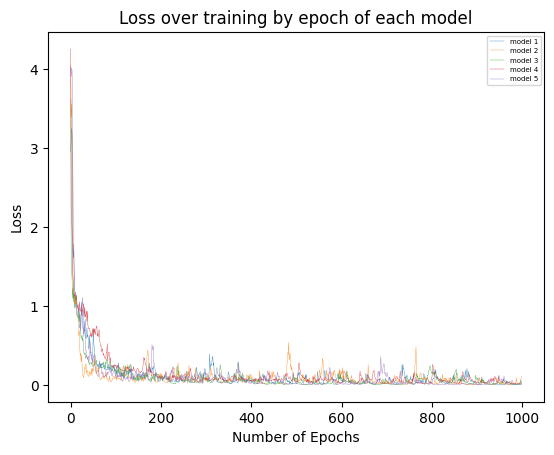

In [127]:
i = 1
for losses in all_losses:
    plt.plot(losses, label=f"model {i}", linewidth=0.25)
    i += 1
plt.legend(fontsize=5)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss over training by epoch of each model")

plt.show()

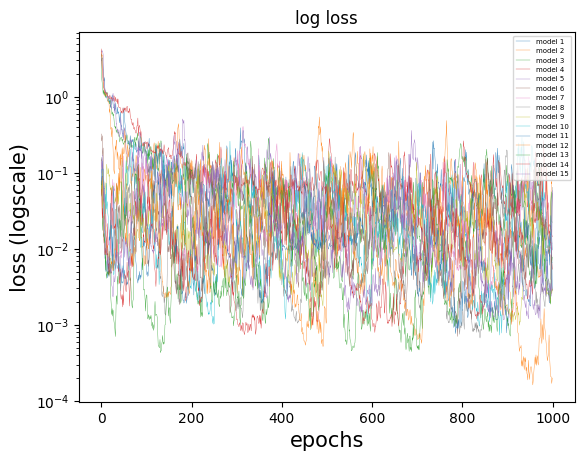

In [134]:
# plt.yscale("log")
# plt.plot(losses)
# plt.title(f"log loss")
# plt.xlabel('epochs', fontsize=15)
# plt.ylabel('loss (logscale)', fontsize=15)
# plt.show()

i = 1
for losses in all_losses:
    plt.plot(losses, label=f"model {i}", linewidth=.25)
    i += 1
plt.title(f"log loss")
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss (logscale)', fontsize=15)
plt.yscale("log")
plt.legend(fontsize=5)
plt.show()

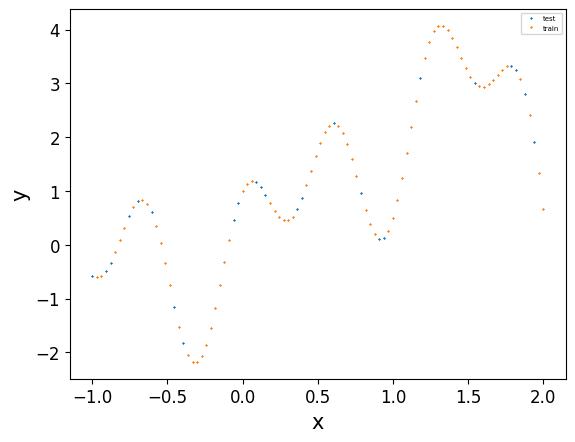

In [112]:
plot_model(train_data, test_data)



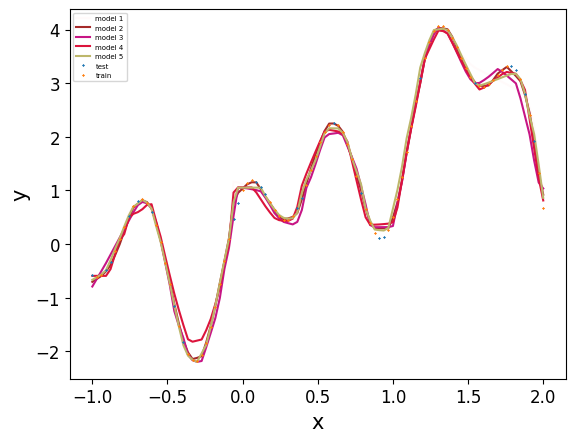

In [113]:
plot_model(train_data, test_data, models)


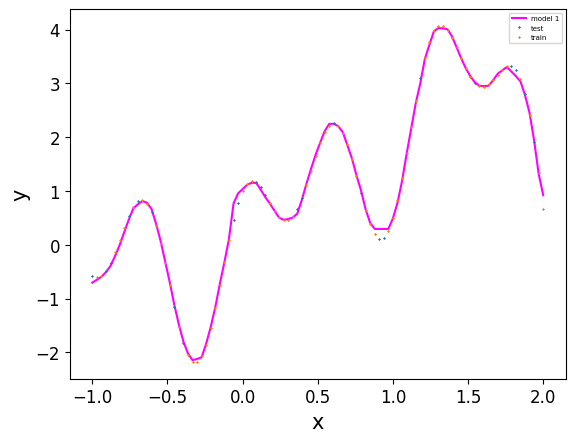

In [124]:
plot_model(train_data, test_data, [models[1]])



In [115]:
all_mse_test = []
all_mse_train = []

all_mae_test = []
all_mae_train = []

all_r2_test = []
all_r2_train = []

all_num_nodes = []
labels = []
with torch.no_grad():
    i = 0 
    while (i < len(models)):
        all_num_nodes.append(sum(dimensions[i]))
        y_pred_train = models[i](train_data.x)
        y_pred_test = models[i](test_data.x)
        
        all_mae_test.append(mean_squared_error(test_data.y,y_pred_test))
        all_mae_train.append(mean_squared_error(train_data.y,y_pred_train))

        all_mse_test.append(mean_absolute_error(test_data.y,y_pred_test))
        all_mse_train.append(mean_absolute_error(train_data.y,y_pred_train))

        all_r2_test.append(r2_score(test_data.y,y_pred_test))
        all_r2_train.append(r2_score(train_data.y,y_pred_train))

        i += 1
        labels.append(f"Model {i}")

            

In [116]:
print(all_num_nodes)

[502, 602, 302, 152, 602]


In [117]:
print(len(all_mse_test))

5


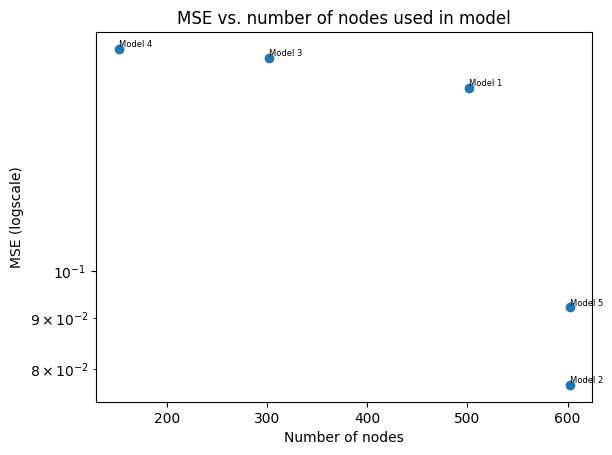

In [118]:
plt.scatter(all_num_nodes, all_mse_test)

for i, label in enumerate(labels):
    plt.text(all_num_nodes[i], all_mse_test[i], label, fontsize=6, ha='left', va='bottom')

plt.xlabel("Number of nodes")
plt.ylabel("MSE (logscale)")
plt.yscale("log")
plt.title("MSE vs. number of nodes used in model")

plt.show()

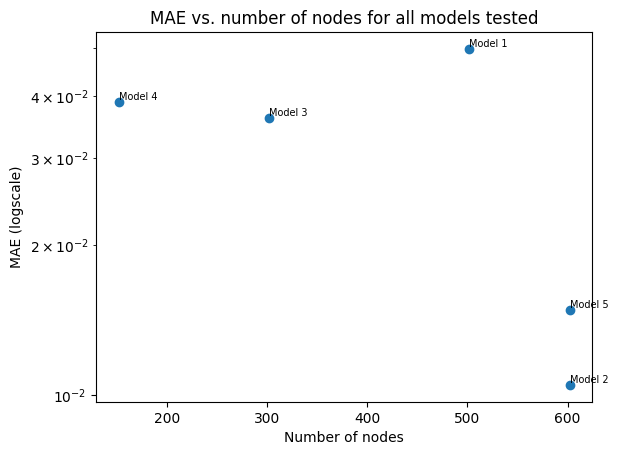

In [119]:
# plt.clf()
plt.scatter(all_num_nodes, all_mae_test)

for i, label in enumerate(labels):
    plt.text(all_num_nodes[i], all_mae_test[i], label, fontsize=7, ha='left', va='bottom')

plt.xlabel("Number of nodes")
plt.ylabel("MAE (logscale)")
plt.yscale("log")
plt.title("MAE vs. number of nodes for all models tested")

plt.show()

In [120]:
print(all_r2_test)

[tensor(0.9711), tensor(0.9941), tensor(0.9779), tensor(0.9767), tensor(0.9919)]


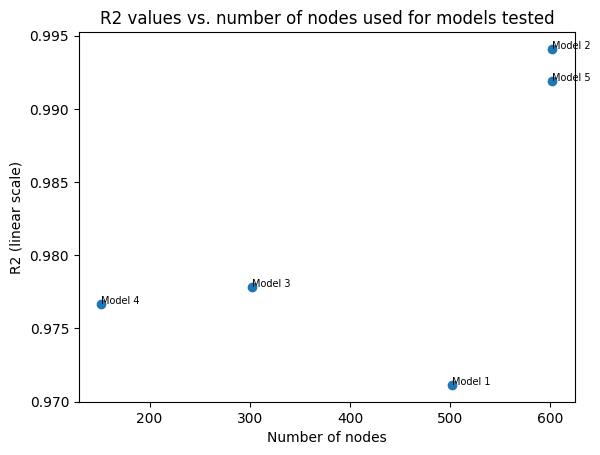

In [129]:

plt.scatter(all_num_nodes, all_r2_test)

for i, label in enumerate(labels):
    plt.text(all_num_nodes[i], all_r2_test[i], label, fontsize=7) #, ha='left', va='bottom')


plt.xlabel("Number of nodes")
plt.title("R2 values vs. number of nodes used for models tested")
plt.ylabel("R2 (linear scale)")
# plt.yscale("log")

plt.show()

In [132]:
all_r2_test[1]

tensor(0.9941)